In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tabulate import tabulate
import re
import seaborn as sns

# formatting
pd.options.display.float_format = '{:,}'.format
table_style = [{'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#eee')]}, 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 {'selector': 'th',
  'props': [('background', '#606060'), 
            ('color', 'white'),
            ('font-family', 'verdana'),
            ("font-size", "90%")]},
 {'selector': 'td',
  'props': [('font-family', 'verdana'), 
            ("font-size", "90%"),
            ("font-weight", "bold")]},
 {'selector': 'tr:hover',
  'props': [('background-color', '#ffffcc')]}
]

bench = {'cut_sgemm-0':0, 'cut_wmma-0': 0, 'parb_stencil-0': 1, 'parb_sgemm-0': 0,
        'parb_lbm-0': 1, 'parb_spmv-0': 1, 'parb_cutcp-0': 0}

def color_CM(s):
    '''
    color compute intensive green and memory intensive red
    '''
    if bench[s['benchmark']] == 0:
        # compute intensive
        return ['color: #5fba7d' for v in s]
    else:
        return ['color: #d65f5f' for v in s]
    
def color_CM_pair(s):
    return ['color: #5fba7d' if bench[v] == 0 else 'color: #d65f5f' for v in s]

def avg_array(s):
    result = [np.average(np.array(v[1:-1].split(' ')).astype(float)) for v in s]
    return result

# Isolated Stats

In [8]:
df = pd.read_csv('seq.csv')
df = df.drop(columns=['gpusim_version', 'jobId', 'config'])
df = df.rename(columns={'pair_str': 'benchmark'})
print(df.columns)

Index(['benchmark', 'grid_x', 'grid_y', 'grid_z', 'block_x', 'block_y',
       'block_z', 'ctas/SM', 'runtime', 'ipc', 'instructions', 'avg_mem_lat',
       'avg_core_to_l2', 'avg_l2_to_core', 'avg_mrq_latency',
       'stall_core_ldst', 'stall_icnt_to_l2', 'l2_BW', 'l2_rshr_entry_fail',
       'l2_rshr_merge_fail', 'stall_l2_to_icnt', 'l1D_miss_rate',
       'l2_miss_rate', 'packet_lat_out', 'network_lat_out', 'inject_out',
       'accepted_out', 'packet_lat_in', 'network_lat_in', 'inject_in',
       'accepted_in', 'mem_subpartition_parallism',
       'mem_subpartition_parallism_util', 'L2_reservation_fail', 'dram_eff',
       'dram_bw', 'row_buffer_locality', 'mrqq', 'total_cmd', 'wasted_col',
       'wasted_row', 'mem_idle', 'CCDLc', 'WTRc', 'RTWc', 'RCDc', 'RCDWRc'],
      dtype='object')


### Basics

In [9]:
df['grid'] = df['grid_x'] * df['grid_y'] * df['grid_z']
df['block'] = df['block_x'] * df['block_y'] * df['block_z']
# df['runtime'] = df['runtime'].astype(float)
df['achieved ctas/SM'] = pd.DataFrame([df['grid'] / 80, df['ctas/SM']]).min() 
df['avg_dram_bw'] = df['dram_bw'].transform(avg_array)


basic = df[['benchmark', 'grid', 'block', 'ctas/SM', 'achieved ctas/SM', 'runtime', 'instructions',
           'l1D_miss_rate', 'l2_miss_rate', 'avg_dram_bw']]


# style the table
basic.style.set_table_styles(table_style).hide_index()\
            .format({'runtime': "{:,}", 'instructions': '{:,}', 
                     'achieved ctas/SM': '{:.1f}', 
#                      'avg_dram_bw':'{:.2f}'
                    })\
            .apply(color_CM, axis=1)


# Observations:
# 1. spmv has a relatively high L1D cache hit rate. We should somehow give higher priority to spmv in L1D

ValueError: could not convert string to float: 

### Memory Latency

In [ ]:
df['time(l2/dram)'] = df['avg_mem_lat'] - df['avg_core_to_l2'] - df['avg_l2_to_core']

l2_hit_lat = 120
dram_lat = 100
df['predict(l2/dram)'] = l2_hit_lat + dram_lat * df['l2_miss_rate']

mem = df[['benchmark', 'avg_mem_lat', 'avg_core_to_l2', 
          'avg_l2_to_core', 'avg_mrq_latency', 'time(l2/dram)', 'predict(l2/dram)']]


# style the table
mem.style.set_table_styles(table_style).hide_index()\
        .format({'avg_mem_lat': "{:,}", 'avg_core_to_l2':'{:,}'})\
        .apply(color_CM, axis=1)

### Stalls (per cycle)

In [ ]:
stall = df[['stall_core_ldst', 'stall_icnt_to_l2', 'l2_rshr_entry_fail',
       'l2_rshr_merge_fail', 'stall_l2_to_icnt']].div(df[['runtime']].iloc[:, 0], axis=0)

stall = pd.concat([df['benchmark'], stall], axis=1)

stall.style.set_table_styles(table_style) \
            .hide_index() \
            .format({'stall_core_ldst':'{:.1f}', 
                     'stall_icnt_to_l2':'{:.1f}', 
                     'l2_rshr_entry_fail':'{:.1f}', 
                     'l2_rshr_merge_fail':'{:.1f}'})\
            .apply(color_CM, axis=1)

# Shared

In [ ]:
sdf = pd.read_csv('conc.csv')
sdf = sdf.drop(columns=['gpusim_version', 'jobId', 'config'])
sdf = sdf.rename(columns={'pair_str': 'benchmark'})


pair = [re.split(r'-(?=\D)', p) for p in sdf['benchmark']]
df_pair = pd.DataFrame(pair, columns=['1_bench', '2_bench'])
sdf = pd.concat([df_pair, sdf], axis=1)

first = pd.merge(sdf['1_bench'], df, right_on='benchmark', left_on='1_bench', how='left')
second = pd.merge(sdf['2_bench'], df, right_on='benchmark', left_on='2_bench', how='left')

print(sdf.columns)

## Basics

In [ ]:
sdf['1_s_ctas/SM'] = pd.DataFrame([first['achieved ctas/SM'], sdf['1_ctas/SM']]).min()
sdf['2_s_ctas/SM'] = pd.DataFrame([second['achieved ctas/SM'], sdf['2_ctas/SM']]).min()

sdf['1_i_ctas/SM'] = first['achieved ctas/SM']
sdf['2_i_ctas/SM'] = second['achieved ctas/SM']

sdf['1_slowdown'] = first['runtime'].div(sdf['1_runtime'])
sdf['2_slowdown'] = second['runtime'].div(sdf['2_runtime'])

sdf['WS'] = sdf['1_slowdown'] + sdf['2_slowdown']

sdf['avg_dram_bw'] = sdf['dram_bw'].transform(avg_array)

s_basic = sdf[['1_bench', '2_bench',
               '1_s_ctas/SM', '1_i_ctas/SM',
                '2_s_ctas/SM', '2_i_ctas/SM',
               'l1D_miss_rate',
               '1_slowdown', '2_slowdown',
               'WS', 'avg_dram_bw']]

def mark_high_slowdown(s):
    return ['background-color: yellow' if v < 0.5 else '' for v in s]

s_basic.style.set_table_styles(table_style)\
            .hide_index()\
            .apply(color_CM_pair, axis=0, subset=['1_bench', '2_bench'])\
            .format({'1_slowdown':'{:.2f}', '2_slowdown':'{:.2f}', 'WS':'{:.2f}'})\
            .apply(mark_high_slowdown, axis=0, subset=['1_slowdown', '2_slowdown'])

#TODO: figure out how to deal with elastic ctas/SM and pricing

## Memory latency

In [ ]:
sdf['1_lat'] = sdf['1_avg_mem_lat'].div(first['avg_mem_lat'])
sdf['2_lat'] = sdf['2_avg_mem_lat'].div(second['avg_mem_lat'])

sdf['1_core_to_l2'] = sdf['1_avg_core_to_l2'].div(first['avg_core_to_l2'])
sdf['2_core_to_l2'] = sdf['2_avg_core_to_l2'].div(second['avg_core_to_l2'])

sdf['1_l2_to_core'] = sdf['1_avg_l2_to_core'].div(first['avg_l2_to_core'])
sdf['2_l2_to_core'] = sdf['2_avg_l2_to_core'].div(second['avg_l2_to_core'])

sdf['1_l2_to_core'] = sdf['1_avg_l2_to_core'].div(first['avg_l2_to_core'])
sdf['2_l2_to_core'] = sdf['2_avg_l2_to_core'].div(second['avg_l2_to_core'])

sdf['1_mrq'] = sdf['1_avg_mrq_latency'].div(first['avg_mrq_latency'])
sdf['2_mrq'] = sdf['2_avg_mrq_latency'].div(second['avg_mrq_latency'])

print('Relative increase (shared / isolated):')

s_mem = sdf[['1_bench',
             '1_lat',
             '1_core_to_l2',
             '1_l2_to_core',
             '1_mrq',
             '2_bench',
             '2_lat',
             '2_l2_to_core',
             '2_core_to_l2',
             '2_mrq',
            ]]

s_mem.style.set_table_styles(table_style)\
        .hide_index()\
        .apply(color_CM_pair, axis=0, subset=['1_bench', '2_bench'])\
        .format({'1_lat':'{:.2f}', '2_lat':'{:.2f}', 
                 '1_core_to_l2':'{:.2f}', '2_core_to_l2':'{:.2f}',
                 '1_l2_to_core':'{:.2f}', '2_l2_to_core':'{:.2f}',
                 '1_mrq':'{:.2f}', '2_mrq':'{:.2f}',
                })

## Stalls (per cycle)

In [ ]:
s_stall = sdf[['stall_core_ldst', 'stall_icnt_to_l2', 'l2_rshr_entry_fail',
       'l2_rshr_merge_fail', 'stall_l2_to_icnt']].div(sdf[['runtime']].iloc[:, 0], axis=0)

s_stall = pd.concat([sdf[['1_bench', '2_bench']], s_stall], axis=1)

s_stall.style.set_table_styles(table_style).hide_index()\
        .apply(color_CM_pair, axis=0, subset=['1_bench', '2_bench'])\
        .format({'stall_core_ldst':'{:.2f}', 'stall_icnt_to_l2':'{:.2f}', 'l2_rshr_entry_fail':'{:.2f}',
       'l2_rshr_merge_fail':'{:.2f}', 'stall_l2_to_icnt':'{:.2f}'})
 


# LBM

In [56]:
ldf = pd.read_csv('lbm-4096.csv')
print(ldf.columns)

Index(['pair_str', 'config', 'gpusim_version', 'jobId', 'grid_x', 'grid_y',
       'grid_z', 'block_x', 'block_y', 'block_z', 'ctas/SM', 'runtime',
       'instructions', 'avg_mem_lat', 'avg_core_to_l2', 'avg_l2_to_core',
       'avg_mrq_latency', 'stall_core_ldst', 'stall_icnt_to_l2', 'l2_BW',
       'l2_rshr_entry_fail', 'l2_rshr_merge_fail', 'stall_l2_to_icnt',
       'l1D_miss_rate', 'l2_miss_rate', 'packet_lat_out', 'network_lat_out',
       'inject_out', 'accepted_out', 'packet_lat_in', 'network_lat_in',
       'inject_in', 'accepted_in', 'mem_subpartition_parallism',
       'mem_subpartition_parallism_util', 'L2_reservation_fail', 'dram_eff',
       'dram_bw', 'row_buffer_locality', 'mrqq', 'total_cmd', 'wasted_col',
       'wasted_row', 'mem_idle', 'CCDLc', 'WTRc', 'RTWc', 'RCDc', 'RCDWRc'],
      dtype='object')


In [57]:
ldf['CTA/SM'] = ldf['config'].apply(lambda x: x[7:-3]).astype(int)
ldf['avg_dram_bw'] = ldf['dram_bw'].transform(avg_array)
ldf['avg_row_locality'] = ldf['row_buffer_locality'].transform(avg_array)
ldf['avg_mrqq'] = ldf['mrqq'].transform(avg_array)
ldf['stall_l2'] = ldf['stall_icnt_to_l2'].div(ldf['runtime']) / 44
ldf['stall_ldst'] = ldf['stall_core_ldst'].div(ldf['runtime'])

l_basic = ldf[['pair_str', 'CTA/SM', 
               'avg_mem_lat', 'avg_core_to_l2', 'avg_l2_to_core', 'avg_mrq_latency', 
               'stall_l2', 'stall_ldst',
               'avg_dram_bw', 'avg_row_locality', 'avg_mrqq',
               'runtime', 'instructions',
               'packet_lat_out', 'network_lat_out',
               'inject_out', 'accepted_out', 'packet_lat_in', 'network_lat_in',
               'inject_in', 'accepted_in'
              ]].sort_values(by=['CTA/SM'])

ldf[['CTA/SM', 'l2_miss_rate']].style.set_table_styles(table_style).hide_index()

CTA/SM,l2_miss_rate
4,0.9996
8,0.9996
11,0.9996
9,0.9996
2,0.9996
10,0.9996
6,0.9996
1,0.9996
3,0.9996
5,0.9996


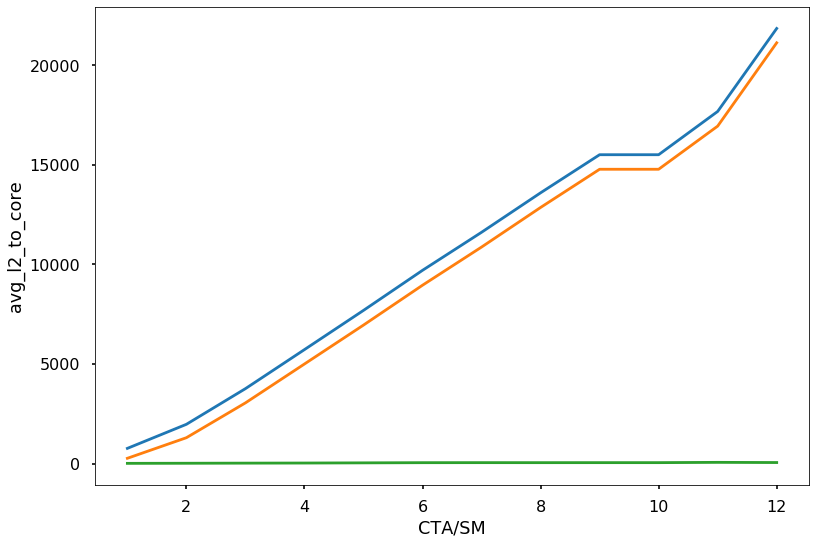

In [55]:
sns.lineplot(x='CTA/SM', y='avg_mem_lat', data=ldf)
sns.lineplot(x=ldf['CTA/SM'], y=ldf['avg_core_to_l2'], data=ldf, legend='full')
sns.lineplot(x=ldf['CTA/SM'], y=ldf['avg_l2_to_core'], data=ldf, legend='full')

## BW v.s. Kernel Performance

In [ ]:
fig, ((ax2, ax3), (ax1, ax4)) = plt.subplots(2, 2, figsize=(10,8))

# FIGURE 1
color = 'tab:red'
ax1.set_xlabel('ctas/SM')
# ax1.set_ylabel('dram_bw', color=color)
# ax1.plot(l_basic['CTA/SM'], l_basic['avg_dram_bw'] , color=color)
# ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('locality', color=color)
ax1.plot(l_basic['CTA/SM'], l_basic['avg_row_locality'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1a = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel('performance', color=color)  # we already handled the x-label with ax1
# ax2.plot(l_basic['CTA/SM'], 1/l_basic['runtime'], color=color)
# ax2.tick_params(axis='y', labelcolor=color)
ax1a.set_ylabel('inverse mrq_latency', color=color)
ax1a.plot(l_basic['CTA/SM'], 1/l_basic['avg_mrq_latency'], color=color)
ax1a.tick_params(axis='y', labelcolor=color)

ax1.set_title('Row Buffer Locality v.s. Inverse mrq Latency')
ax1.grid(True, axis='x')
ax1.set_xticks(np.arange(1,13,1))

# FIGURE 2
color = 'tab:red'
ax2.set_xlabel('ctas/SM')
ax2.set_ylabel('dram_bw', color=color)
ax2.plot(l_basic['CTA/SM'], l_basic['avg_dram_bw'] , color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2a = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2a.set_ylabel('IPC', color=color)  # we already handled the x-label with ax1
# ax2a.plot(l_basic['CTA/SM'], ldf['instructions'].div(l_basic['runtime']), color=color)
ax2a.plot(l_basic['CTA/SM'], l_basic['instructions']/l_basic['runtime'], color=color)
ax2a.tick_params(axis='y', labelcolor=color)

ax2.set_title('DRAM Bandwidth v.s. IPC')
ax2.grid(True, axis='x')
ax2.set_xticks(np.arange(1,13,1))

# FIGURE 3
color = 'tab:red'
ax3.set_xlabel('ctas/SM')
ax3.set_ylabel('dram_bw', color=color)
ax3.plot(l_basic['CTA/SM'], l_basic['avg_dram_bw'] , color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax3a = ax3.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3a.set_ylabel('inverse mrq_latency', color=color)  # we already handled the x-label with ax1
# ax2a.plot(l_basic['CTA/SM'], ldf['instructions'].div(l_basic['runtime']), color=color)
ax3a.plot(l_basic['CTA/SM'], 1/l_basic['avg_mrq_latency'], color=color)
ax3a.tick_params(axis='y', labelcolor=color)

ax3.set_title('DRAM Bandwidth v.s. Inverse mrq Latency')
ax3.grid(True, axis='x')
ax3.set_xticks(np.arange(1,13,1))

# FIGURE 4
color = 'tab:red'
ax4.set_xlabel('ctas/SM')
ax4.set_ylabel('mrqq', color=color)
ax4.plot(l_basic['CTA/SM'], l_basic['avg_mrqq'] , color=color)
ax4.tick_params(axis='y', labelcolor=color)

ax4a = ax4.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4a.set_ylabel('inverse mrq_latency', color=color)  # we already handled the x-label with ax1
# ax2a.plot(l_basic['CTA/SM'], ldf['instructions'].div(l_basic['runtime']), color=color)
ax4a.plot(l_basic['CTA/SM'], 1/l_basic['avg_mrq_latency'], color=color)
ax4a.tick_params(axis='y', labelcolor=color)

ax4.set_title('mrqq v.s. Inverse mrq Latency')
ax4.grid(True, axis='x')
ax4.set_xticks(np.arange(1,13,1))



fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Observations:
# 1. performance is positively correlated with dram bandwidth utilization
# 2. mrq latency going down might be because as the number of requests increases, 
# the row buffer locality improves??  

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))

# FIGURE 1
color = 'tab:red'
ax1.set_xlabel('ctas/SM')
ax1.set_ylabel('core_l2_latency', color=color)
ax1.plot(l_basic['CTA/SM'], l_basic['avg_core_to_l2'] , color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1a = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1a.set_ylabel('stall_l2', color=color)  # we already handled the x-label with ax1
ax1a.plot(l_basic['CTA/SM'], l_basic['stall_l2'], color=color)
ax1a.tick_params(axis='y', labelcolor=color)

ax1.set_title('core to l2 latency v.s. stall at l2')
ax1.grid(True, axis='x')
ax1.set_xticks(np.arange(1,13,1))

# FIGURE 2
color = 'tab:red'
ax2.set_xlabel('ctas/SM')
ax2.set_ylabel('dram_bw', color=color)
ax2.plot(l_basic['CTA/SM'], l_basic['avg_dram_bw'] , color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2a = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2a.set_ylabel('stall_ldst', color=color)  # we already handled the x-label with ax1
ax2a.plot(l_basic['CTA/SM'], l_basic['stall_ldst'], color=color)
ax2a.tick_params(axis='y', labelcolor=color)

ax2.set_title('core to l2 latency v.s. stall at ldst')
ax2.grid(True, axis='x')
ax2.set_xticks(np.arange(1,13,1))


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Observation: 
# core to l2 latency isn't really correlated with stalls at L2/LdST unit, 
# maybe interconnect is the problem??
# Gennady:
# this curve is basically perfectly linear -> should never happen on a simulator
# the interconnect should follow queueing delay (non-linear increase in latency)
# in reality, the performance of the interconnect should never be a bottleneck (provisioned enough)
# so that real applications are either compute bound or memory bound

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))

# FIGURE 1
color = 'tab:red'
ax1.set_xlabel('ctas/SM')
ax1.set_ylabel('latency')
ax1.plot(l_basic['CTA/SM'], l_basic['packet_lat_out'] , color=color)
ax1.tick_params(axis='y')

#ax1a = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
#ax1.set_ylabel('network_lat_out', color=color)  # we already handled the x-label with ax1
ax1.plot(l_basic['CTA/SM'], l_basic['network_lat_out'], color=color)
#ax1a.tick_params(axis='y', labelcolor=color)
ax1.legend(['packet latency (out)', 'network latency (out)'])

ax1.set_title('packet latency v.s network latency')
ax1.grid(True, axis='x')
ax1.set_xticks(np.arange(1,13,1))

# FIGURE 2
color = 'tab:red'
ax2.set_xlabel('ctas/SM')
ax2.set_ylabel('inject_out', color=color)
ax2.plot(l_basic['CTA/SM'], l_basic['inject_out'] , color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2a = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2a.set_ylabel('dram_bw', color=color)  # we already handled the x-label with ax1
ax2a.plot(l_basic['CTA/SM'], l_basic['avg_dram_bw'], color=color)
ax2a.tick_params(axis='y', labelcolor=color)

ax2.set_title('injection rate (outbound) v.s. dram bw')
ax2.grid(True, axis='x')
ax2.set_xticks(np.arange(1,13,1))


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Observation: 
# injection rate to the interconnect is correlated with the dram bandwidth util?????????????

## LBM (NOC buffer changes)

In [12]:
# current_palette = sns.color_palette()

# Dram BW changes as the NOC configs change
def extract_df(filename):
    _df = pd.read_csv(filename)
    _df['CTA/SM'] = _df['config'].apply(lambda x: x.split('-')[1][0:-3]).astype(int)
    _df['avg_dram_bw'] = _df['dram_bw'].transform(avg_array)
    _df['IPC'] = _df['instructions'] / _df['runtime']
    _df['avg_row_locality'] = _df['row_buffer_locality'].transform(avg_array)
    
    _df['total_cmd'] = _df['total_cmd'].transform(avg_array)
    _df['frac_wasted_col'] = _df['wasted_col'].transform(avg_array) / _df['total_cmd']
    _df['frac_wasted_row'] = _df['wasted_row'].transform(avg_array) / _df['total_cmd']
    _df['frac_mem_idle'] = _df['mem_idle'].transform(avg_array) / _df['total_cmd']
    _df['frac_CCDLc'] = _df['CCDLc'].transform(avg_array) / _df['total_cmd']
    _df['frac_WTRc'] = _df['WTRc'].transform(avg_array) / _df['total_cmd']
    _df['frac_RTWc'] = _df['RTWc'].transform(avg_array) / _df['total_cmd']
    _df['frac_RCDc'] = _df['RCDc'].transform(avg_array) / _df['total_cmd']
    _df['frac_RCDWRc'] = _df['RCDWRc'].transform(avg_array) / _df['total_cmd']
    
    
#     return _df[['CTA/SM', 
#                 'avg_dram_bw', 'avg_row_locality',
#                 'IPC', 'avg_mem_lat',
#                   ]].sort_values(by=['CTA/SM'])
    return _df.sort_values(by=['CTA/SM'])

def draw_fig(df_in, axis, title, ylim_left=[0.6, 0.74], ylim_right=[420, 490], left='avg_dram_bw', right='IPC'):
    color_red = sns.xkcd_rgb["pale red"]
    color_blue = sns.xkcd_rgb["denim blue"]

    axis.set_xlabel('ctas/SM')
    axis.set_ylabel('dram_bw', color=color_red, fontsize=12)
    axis.plot(df_in['CTA/SM'], df_in[left], color=color_red)
    axis.tick_params(axis='y', labelcolor=color_red)
#     axis.set_ylim([0.5, 0.74])
    axis.set_ylim(ylim_left)
    axis.set_axisbelow(True)

    axis1 = axis.twinx()  # instantiate a second axes that shares the same x-axis

    axis1.set_ylabel('IPC', color=color_blue, fontsize=12)
    axis1.plot(df_in['CTA/SM'], df_in[right], color=color_blue)
    axis1.tick_params(axis='y', labelcolor=color_blue)
#     axis1.set_ylim([420, 490])
    axis1.set_ylim(ylim_right)

    axis1.set_title(title)
    axis1.set_xticks(df_in['CTA/SM'])
    axis1.set_axisbelow(True)
    axis1.grid(True)
    


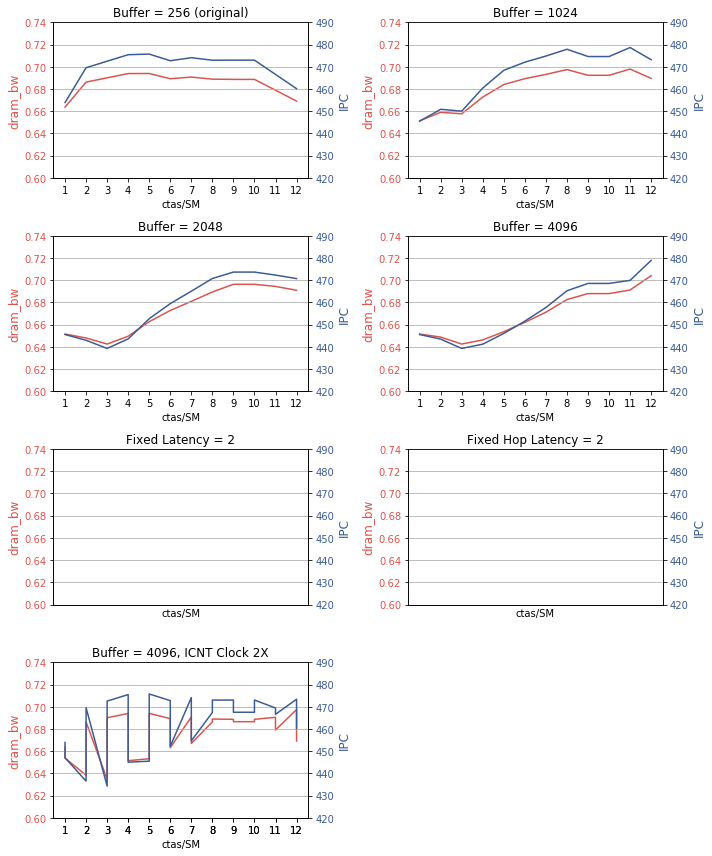

In [13]:
df_256 = extract_df('lbm-256.csv')
df_1000 = extract_df('lbm-1024.csv')
df_2000 = extract_df('lbm-2048.csv')
df_3000 = extract_df('lbm-4096.csv')
df_fixed = extract_df('lbm-fixed.csv')
df_hop = extract_df('lbm-hop.csv')
df_clk2x = extract_df('lbm-clk2x.csv')
# df_bypassl2 = extract_df('lbm-bypassl2.csv')

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(10,12))

draw_fig(df_256, ax1, 'Buffer = 256 (original)')
draw_fig(df_1000, ax2, 'Buffer = 1024')
draw_fig(df_2000, ax3, 'Buffer = 2048')
draw_fig(df_3000, ax4, 'Buffer = 4096')
draw_fig(df_fixed, ax5, 'Fixed Latency = 2')
draw_fig(df_hop, ax6, 'Fixed Hop Latency = 2')
draw_fig(df_clk2x, ax7, 'Buffer = 4096, ICNT Clock 2X')
fig.delaxes(ax8)

#draw_fig(df_clk2x, ax7, '2X ICNT Clock')
# draw_fig(df_bypassl2, ax8, 'Bypass L2, Buffer = 4096')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('buffers.pdf')
# plt.show()

# Observation:
# 1. the trends of DRAM bandwidth and IPC are very correlated in all NOC configs
# 2. Even though IPC reaches max when CTA/SM is less than 12 when the buffer is small (256), most of the CTA/SM
# configs can achieve a high IPC compared with other NOC configs
# 3. When the buffer size is medium (1000, 20000), the trend in IPC starts to plateu around CTA/SM = 8. But when
# the buffer size is large (3000), IPC continues to rise beyond 8 CTA/SM

## Bypass L2

In [14]:
def draw_fig_legend(_dfs, y, ylim, axis, title, legends, ylabel):
#     mpl.style.use('seaborn-paper')
    mpl.style.use('seaborn-poster')
    axis.set_xlabel('ctas/SM')
    axis.set_xticks(_dfs[0]['CTA/SM'])
    axis.set_ylabel(ylabel)
    axis.set_ylim(ylim)
    axis.grid(True, axis='y')
    axis.set_axisbelow(True)
    axis.set_title(title)

    for _df in _dfs:
        axis.plot(_df['CTA/SM'], _df[y])

    axis.legend(legends)


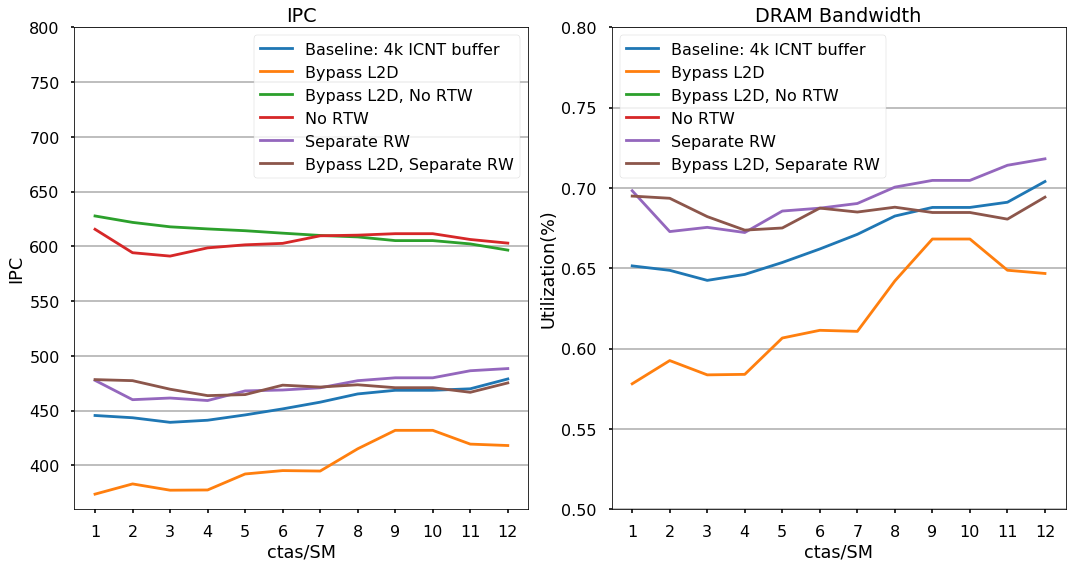

In [26]:
df_4k = extract_df('lbm-4096.csv')
# df_bypassl2 = extract_df('lbm-bypassl2.csv')
df_bypassl2d = extract_df('lbm-bypassl2d.csv')
df_bypassl2d_nortw = extract_df('lbm-bypassl2d-nortw.csv')
df_nortw = extract_df('lbm-nortw.csv')
df_seprw = extract_df('lbm-seprw.csv')
df_bypassl2d_seprw = extract_df('lbm-bypassl2d-seprw.csv')

# df_bypassl2d_throttle_nortw = extract_df('lbm-bypassl2d-throttle-nortw.csv')
# df_bypassl2d_throttle = extract_df('lbm-bypassl2d-throttle.csv')

df_list = [df_4k, df_bypassl2d, 
           df_bypassl2d_nortw, df_nortw, 
           df_seprw, df_bypassl2d_seprw
          ]

legends = ['Baseline: 4k ICNT buffer', 'Bypass L2D', 
           'Bypass L2D, No RTW', 'No RTW',
           'Separate RW', 'Bypass L2D, Separate RW'
          ]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,20))

# ylim_bw = [0.5, 0.8]
# ylim_ipc = [360, 480]
# ylim_lat = [400, 18000]
# draw_fig(df_4k, ax1, 'Buffer = 4096 (baseline)', ylim_left=ylim_bw, ylim_right=ylim_ipc)
# draw_fig(df_bypassl2, ax2, 'Bypass L2', ylim_left=ylim_bw, ylim_right=ylim_ipc)
# draw_fig(df_4k, ax3, 'Buffer = 4096 (baseline)', ylim_left=ylim_bw, right='avg_mem_lat', ylim_right=ylim_lat)
# draw_fig(df_bypassl2, ax4, 'Bypass L2', ylim_left=ylim_bw, right='avg_mem_lat', ylim_right=ylim_lat)

# IPC comparison chart


draw_fig_legend(df_list, 'IPC', [360, 800], axis=ax1, title='IPC', 
                legends=legends, ylabel = 'IPC')
draw_fig_legend(df_list, 'avg_dram_bw', [0.5, 0.8], axis=ax2, title='DRAM Bandwidth',
               legends=legends, ylabel='Utilization(%)')
# draw_fig_legend(df_list, 'avg_mem_lat', [500, 20000], axis=ax3, title='Memory Latency',
#                legends=legends, ylabel='Latency (cycles)')
# draw_fig_legend(df_list, 'l2_BW', [300, 700], axis=ax4, title='L2 Bandwidth',
#                legends=legends, ylabel='Banwidth (GB/s)')
# draw_fig_legend(df_list, 'frac_wasted_col', [0, 0.6], axis=ax3, title='Wasted Column',
#                legends=legends, ylabel='Fraction')
# draw_fig_legend(df_list, 'frac_CCDLc', [0, 0.6], axis=ax4, title='CCDLc',
#                legends=legends, ylabel='Fraction')
# draw_fig_legend(df_list, 'frac_RCDc', [0, 0.4], axis=ax5, title='RCDc',
#                legends=legends, ylabel='Fraction')
# draw_fig_legend(df_list, 'frac_RTWc', [0, 2], axis=ax8, title='RTWc',
#                legends=legends, ylabel='Fraction')
# draw_fig_legend(df_list, 'frac_RCDWRc', [0, 0.5], axis=ax6, title='RCDWRc',
#                legends=legends, ylabel='Fraction')



# draw_fig_legend(df_list, 'frac_mem_idle', [0, 0.1], axis=ax7, title='DRAM Idle',
#                legends=legends, ylabel='Fraction')
# fig.delaxes(ax8)
# draw_fig_legend(df_list, 'mem_subpartition_parallism', [0, 48], axis=ax5, title='Memory Subpartition Parallelism',
#                legends=legends)
# draw_fig_legend(df_list, 'mem_subpartition_parallism_util', [0, 48], axis=ax6, 
#                 title='Memory Subpartition Parallelism Util',
#                 legends=legends)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('bypassl2_v3.pdf')